In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import tensorflow as tf
print(tf.__version__)
import gc
#from talos.model.layers import hidden_layers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LocallyConnected1D, Conv2D, Reshape, Dropout, MaxPool2D, Flatten
from keras.callbacks import ModelCheckpoint, History, EarlyStopping
from keras.activations import relu, elu, linear
from keras import backend as K
from keras import regularizers
from keras.datasets import mnist
from keras.utils import np_utils
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split

from tqdm import trange

plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [10.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18

2.0.0


Using TensorFlow backend.


## Loading Data

In [2]:
X_train = np.load("../data/X_train.npy")
X_test = np.load("../data/X_test.npy")
X_val = np.load("../data/X_val.npy")
Y_train = np.load("../data/Y_train.npy")
Y_test = np.load("../data/Y_test.npy")
Y_val = np.load("../data/Y_val.npy")
Y_onehot_train = np_utils.to_categorical(Y_train)
Y_onehot_test = np_utils.to_categorical(Y_test)
Y_onehot_val = np_utils.to_categorical(Y_val)

nr_params = X_train.shape[1]

## Creating general model function

In [3]:
def make_dense_model(params):
    opti = optimizers.Adam(amsgrad=True, lr=params["lr"])
    def nn_clf():
        model = Sequential()
        model.add(Dense(params["nr_neurons"], activation ="relu", input_shape = (nr_params,)))
        for i in range(1, params["nr_layers"]):
            model.add(Dense(params["nr_neurons"]//(i**2), activation ="relu"))
        model.add(Dense(10, activation = "softmax"))
        model.compile(optimizer=opti, loss="categorical_crossentropy",  metrics=["accuracy"])
        return model
    return nn_clf

## Test run

In [ ]:
params = {
    "batch_size" : 1024,
    "lr" : 1e-3,
    "nr_neurons" : 1024,
    "nr_layers" : 5
}

In [ ]:
callbacks = [EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=10, verbose=1, restore_best_weights=True)]
clf = KerasClassifier(build_fn=make_dense_model(params), batch_size=params["batch_size"], epochs=100, validation_data=(X_test, Y_onehot_test), callbacks=callbacks, verbose=1)
history = clf.fit(X_train, Y_onehot_train)
Y_pred = clf.predict(X_test)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(history.history["val_accuracy"], c="crimson")
plt.plot(history.history["accuracy"], c="navy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

## Hyperparameter Optimization
### Learning Rate vs Batch Size

In [4]:
all_params = {
    "batch_size" : [8, 64, 512, 4096],
    "lr" : [1e-2, 1e-3, 1e-4]
}
nr_runs = len(all_params['batch_size'])*len(all_params["lr"])

In [6]:
hp_dict = {
    "acc_score" : [],
    "batch_size" : [],
    "lr" : []
}

k = 0
t0 = time.time()
for batch_size in all_params["batch_size"]:
    for lr in all_params["lr"]:
        params = {
            "batch_size" : batch_size,
            "lr" : lr,
            "nr_layers" : 5,
            "nr_neurons" : 1024
             }

        hp_dict["batch_size"].append(batch_size)
        hp_dict["lr"].append(lr)

        callbacks = [EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=10, verbose=1, restore_best_weights=True)]
        model = make_dense_model(params)
        clf = KerasClassifier(build_fn=model, batch_size=params["batch_size"], epochs=200, validation_data=(X_test, Y_onehot_test), callbacks=callbacks, verbose=0)
        history = clf.fit(X_train, Y_onehot_train)
        Y_pred = clf.predict(X_val)
        del history, clf, model
        gc.collect()
        K.clear_session()
        hp_dict["acc_score"].append(accuracy_score(Y_val, Y_pred))

        k += 1
        print(f"{100*k/nr_runs:.1f} %, {(time.time()-t0)/60:.1f} m")

Restoring model weights from the end of the best epoch
Epoch 00032: early stopping
8.3 %, 40.2 m
Restoring model weights from the end of the best epoch
Epoch 00028: early stopping
16.7 %, 75.1 m
Restoring model weights from the end of the best epoch
Epoch 00030: early stopping
25.0 %, 112.5 m
Restoring model weights from the end of the best epoch
Epoch 00030: early stopping
33.3 %, 117.9 m
Restoring model weights from the end of the best epoch
Epoch 00041: early stopping
41.7 %, 125.3 m
Restoring model weights from the end of the best epoch
Epoch 00034: early stopping
50.0 %, 131.5 m
Restoring model weights from the end of the best epoch
Epoch 00028: early stopping
58.3 %, 132.8 m
Restoring model weights from the end of the best epoch
Epoch 00025: early stopping
66.7 %, 134.0 m
Restoring model weights from the end of the best epoch
Epoch 00040: early stopping
75.0 %, 135.9 m
Restoring model weights from the end of the best epoch
Epoch 00044: early stopping
83.3 %, 137.3 m
Restoring mod

In [7]:
hp_df = pd.DataFrame.from_dict(hp_dict)
hp_df.to_pickle("../data/hp_df_DNN_lr_batch.pickle")

In [8]:
hp_df

,acc_score,batch_size,lr
0,0.7966,8,0.0100
1,0.8982,8,0.0010
2,0.9054,8,0.0001
3,0.8730,64,0.0100
4,0.9037,64,0.0010
5,0.9012,64,0.0001
6,0.8819,512,0.0100
7,0.9018,512,0.0010
8,0.8994,512,0.0001
9,0.8848,4096,0.0100


## Network Size

In [9]:
all_params = {
    "nr_layers" : [1, 2, 4, 6, 10],
    "nr_neurons" : [256, 512, 1024, 2048, 4096]
}
nr_runs = len(all_params['nr_layers'])*len(all_params["nr_neurons"])

In [13]:
hp_dict = {
    "acc_score" : [],
    "nr_layers" : [],
    "nr_neurons" : []
}

k = 0
t0 = time.time()
for nr_layers in all_params["nr_layers"]:
    for nr_neurons in all_params["nr_neurons"]:
        params = {
            "batch_size" : 512,
            "lr" : 1e-3,
            "nr_layers" : nr_layers,
            "nr_neurons" : nr_neurons
             }

        hp_dict["nr_layers"].append(nr_layers)
        hp_dict["nr_neurons"].append(nr_neurons)

        callbacks = [EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=10, verbose=1, restore_best_weights=True)]
        model = make_dense_model(params)
        clf = KerasClassifier(build_fn=model, batch_size=params["batch_size"], epochs=200, validation_data=(X_test, Y_onehot_test), callbacks=callbacks, verbose=0)
        history = clf.fit(X_train, Y_onehot_train)
        Y_pred = clf.predict(X_val)
        del history, clf, model
        gc.collect()
        K.clear_session()
        hp_dict["acc_score"].append(accuracy_score(Y_val, Y_pred))

        k += 1
        print(f"{100*k/nr_runs:.1f} %, {(time.time()-t0)/60:.1f} m")

Restoring model weights from the end of the best epoch
Epoch 00044: early stopping
4.0 %, 0.4 m
Restoring model weights from the end of the best epoch
Epoch 00058: early stopping
8.0 %, 1.2 m
Restoring model weights from the end of the best epoch
Epoch 00037: early stopping
12.0 %, 1.9 m
Restoring model weights from the end of the best epoch
Epoch 00037: early stopping
16.0 %, 3.1 m
Restoring model weights from the end of the best epoch
Epoch 00033: early stopping
20.0 %, 5.3 m
Restoring model weights from the end of the best epoch
Epoch 00029: early stopping
24.0 %, 5.6 m
Restoring model weights from the end of the best epoch
Epoch 00039: early stopping
28.0 %, 6.3 m
Restoring model weights from the end of the best epoch
Epoch 00032: early stopping
32.0 %, 7.6 m
Restoring model weights from the end of the best epoch
Epoch 00023: early stopping
36.0 %, 10.4 m
Restoring model weights from the end of the best epoch
Epoch 00025: early stopping
40.0 %, 21.6 m
Restoring model weights from t

In [14]:
hp_df = pd.DataFrame.from_dict(hp_dict)
hp_df.to_pickle("../data/hp_df_DNN_network_size.pickle")

In [15]:
hp_df

,acc_score,nr_layers,nr_neurons
0,0.8970,1,256
1,0.9014,1,512
2,0.9055,1,1024
3,0.9091,1,2048
4,0.9050,1,4096
5,0.8987,2,256
6,0.9010,2,512
7,0.9013,2,1024
8,0.9008,2,2048
9,0.9000,2,4096


In [19]:
hp_matrix = np.zeros((5, 5))
for i in range(5):
    for j in range(5):
        hp_matrix[i,j] = hp_df["acc_score"].iloc[i+j*5]

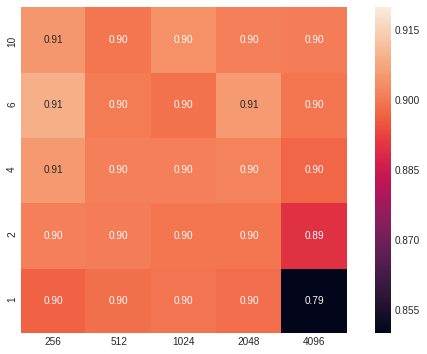

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
sns.heatmap(hp_matrix, ax=ax, annot=True, fmt=".2f", vmin=0.85, vmax=0.92, square=True, xticklabels=all_params["nr_neurons"], yticklabels=all_params["nr_layers"])
plt.ylim(0, 5);